In [1]:
!pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from transformers import AutoImageProcessor, ViTModel
import torch
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
BASE_PATH = '/content/images/'
INPUT_IMAGE = 'input.png'

In [4]:
# load the image
image_path = BASE_PATH + INPUT_IMAGE
image = Image.open(image_path).convert('RGB')

model_name = 'google/vit-base-patch16-224-in21k'

# preprocess image + model outputs
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = ViTModel.from_pretrained(model_name)
model_inputs = image_processor(image, return_tensors="pt")

# Attention visualization

## Steps

1.   **Attention Matrix Extraction**: Extract the attention matrices for each layer.

2.   **Average Attention**: The attention matrices from all heads are averaged along the head dimension to obtain a single attention matrix for each layer.

3.   **Residual Matrix**: A residual matrix is added to the averaged attention matrix to account for residual connections in the Transformer model. Residual connections enable the model to retain information from previous layers.

4.   **Normalization**: The augmented attention matrix (averaged attention + residual matrix) is normalized by dividing each row by the sum of its elements. This normalization ensures that the attention weights remain in the range [0, 1] and represent a valid probability distribution.

5.   **Joint Attention Calculation**: The code recursively multiplies the augmented attention matrices from the first layer to the last layer to obtain joint attentions.

6.   **Attention Visualization**: The attention weights from the joint attentions are used to create a visualization mask. The mask is resized to match the input image size and multiplied element-wise with the original image to highlight the regions of importance according to the attention weights.


## model output

In [5]:
with torch.no_grad():
    outputs = model(**model_inputs, output_attentions=True)

# Extract attention from the output
attentions = outputs['attentions']
attentions = torch.stack(attentions).squeeze()
print(f"Attention shape {attentions.shape}")

Attention shape torch.Size([12, 12, 197, 197])


## Fusion by heads mean

In [6]:
# Average the attention weights across all heads.
attentions = torch.mean(attentions, dim=1)
print(f"Attention shape {attentions.shape}")

Attention shape torch.Size([12, 197, 197])


In [7]:
# identity matrix
residual_attentions = torch.eye(attentions.size(1))
residual_attentions = attentions + residual_attentions
# average the weights.
avg_attentions = residual_attentions / residual_attentions.sum(dim=-1).unsqueeze(-1)
print(f"Attention shape {avg_attentions.shape}")

Attention shape torch.Size([12, 197, 197])


## Calculate joint attention matrix

In [8]:
joint_attentions = torch.zeros(avg_attentions.size())
joint_attentions[0] = avg_attentions[0]

for n in range(1, avg_attentions.size(0)):
    joint_attentions[n] = torch.matmul(avg_attentions[n], joint_attentions[n - 1])

joint_attentions.shape

torch.Size([12, 197, 197])

## Visualize last attention map

In [9]:
last_attention = joint_attentions[-1]
grid_size = int(np.sqrt(avg_attentions.shape[-1]))

# remove attention special token
mask = last_attention[0, 1:].reshape(grid_size, grid_size).detach().numpy()
# normalize the mask
mask = cv2.resize(mask / mask.max(), image.size)
mask = np.expand_dims(mask, axis=-1)

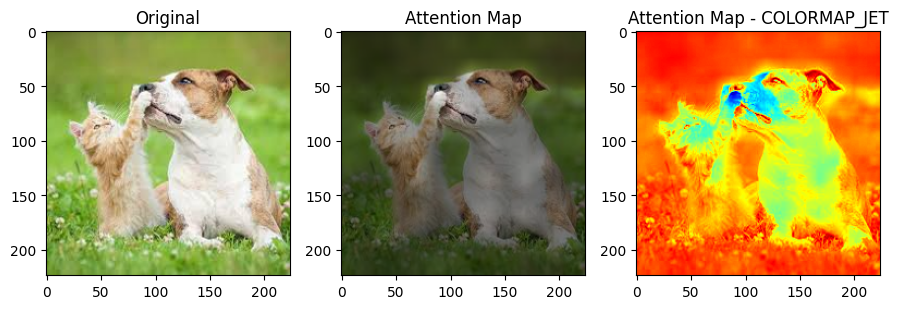

In [10]:
# calculate attention map for image
attention_map_image = (mask * image).astype("uint8")
attention_map_image_jitter = cv2.applyColorMap(attention_map_image, cv2.COLORMAP_JET)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 9))

axes[0].set_title('Original')
axes[1].set_title('Attention Map')
axes[2].set_title('Attention Map - COLORMAP_JET')

axes[0].imshow(image)
axes[1].imshow(attention_map_image)
axes[2].imshow(attention_map_image_jitter)

plt.tight_layout()
plt.show()

## Visualize Attention map of each layer

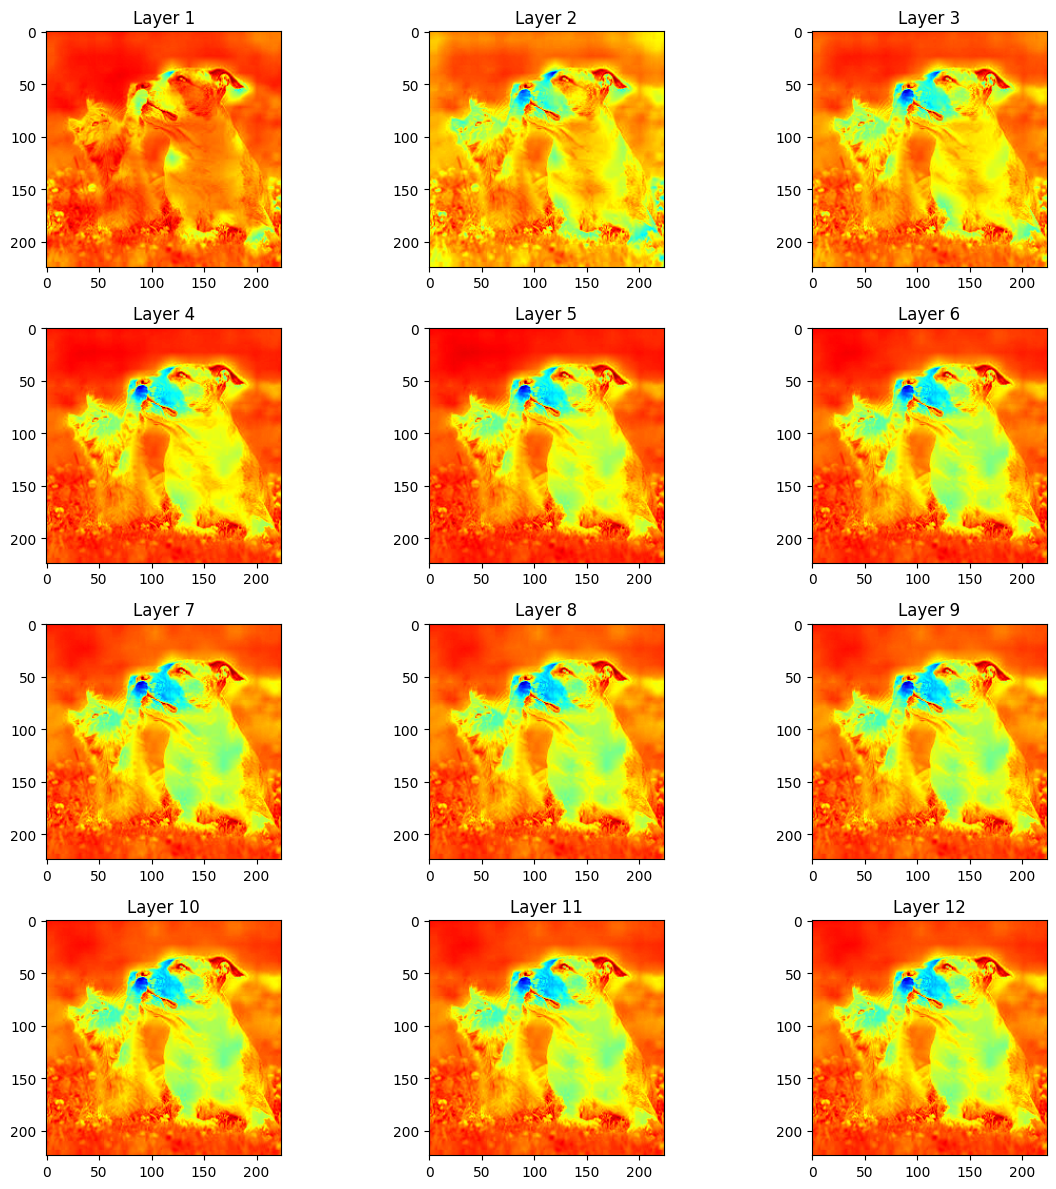

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

for index, attention_layer in enumerate(joint_attentions):
  plt.subplot(4,3, index+1)
  # remove attention special token
  mask = attention_layer[0, 1:].reshape(grid_size, grid_size).detach().numpy()
  mask = cv2.resize(mask / mask.max(), image.size)
  # normalize the mask
  mask = np.expand_dims(mask, axis=-1)

  attention_map_image = (mask * image).astype("uint8")
  attention_map_image_jitter = cv2.applyColorMap(attention_map_image, cv2.COLORMAP_JET)

  plt.title(f"Layer {index + 1}")
  plt.imshow(attention_map_image_jitter)

plt.tight_layout()
plt.show()


# Roll Out - Attention map

**Github Code**- https://github.com/jacobgil/vit-explain/blob/main/vit_explain.py

**Github Explanation** - https://jacobgil.github.io/deeplearning/vision-transformer-explainability

Visualization variables:


*   Discard ratio - Remove ratio, good to remove noise
*   Head fusion - Fusion heads by Min, Mean, Max.
*   Category index - To explain specific class






In [12]:
def plot_images(images_path, images_title, nrows, ncols, figsize):

  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
  index = 0

  for row in range(nrows):
    for col in range(ncols):
      image_path = images_path[index]
      plt.subplot(nrows, ncols, index+1)
      full_path = BASE_PATH + image_path
      image = Image.open(full_path).convert('RGB')
      plt.imshow(image)
      plt.title(images_title[index])
      index+=1
  plt.tight_layout()
  plt.show()


## No category visualization

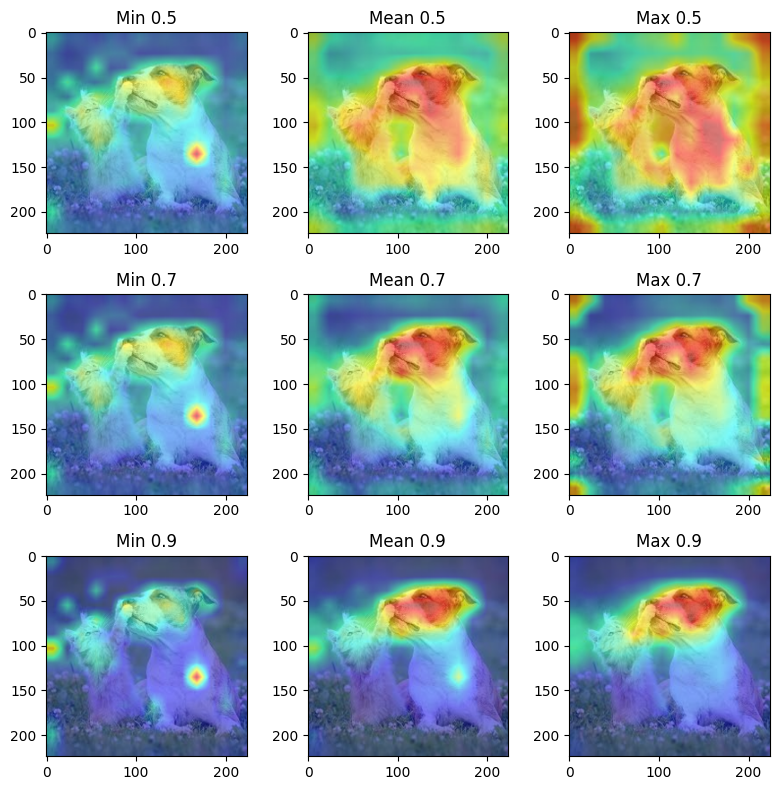

In [13]:
head_fusion_no_category_images = ['cat_dog_no_category_attention_rollout_0.500_min.png',
                           'cat_dog_no_category_attention_rollout_0.500_mean.png',
                           'cat_dog_no_category_attention_rollout_0.500_max.png',
                           'cat_dog_no_category_attention_rollout_0.700_min.png',
                           'cat_dog_no_category_attention_rollout_0.700_mean.png',
                           'cat_dog_no_category_attention_rollout_0.700_max.png',
                           'cat_dog_no_category_attention_rollout_0.900_min.png',
                           'cat_dog_no_category_attention_rollout_0.900_mean.png',
                           'cat_dog_no_category_attention_rollout_0.900_max.png']

head_fusion_no_category_titles = ['Min 0.5', 'Mean 0.5', 'Max 0.5',
                                  'Min 0.7', 'Mean 0.7', 'Max 0.7',
                                  'Min 0.9', 'Mean 0.9', 'Max 0.9']

plot_images(head_fusion_no_category_images, head_fusion_no_category_titles, nrows=3, ncols=3, figsize=(8,8))


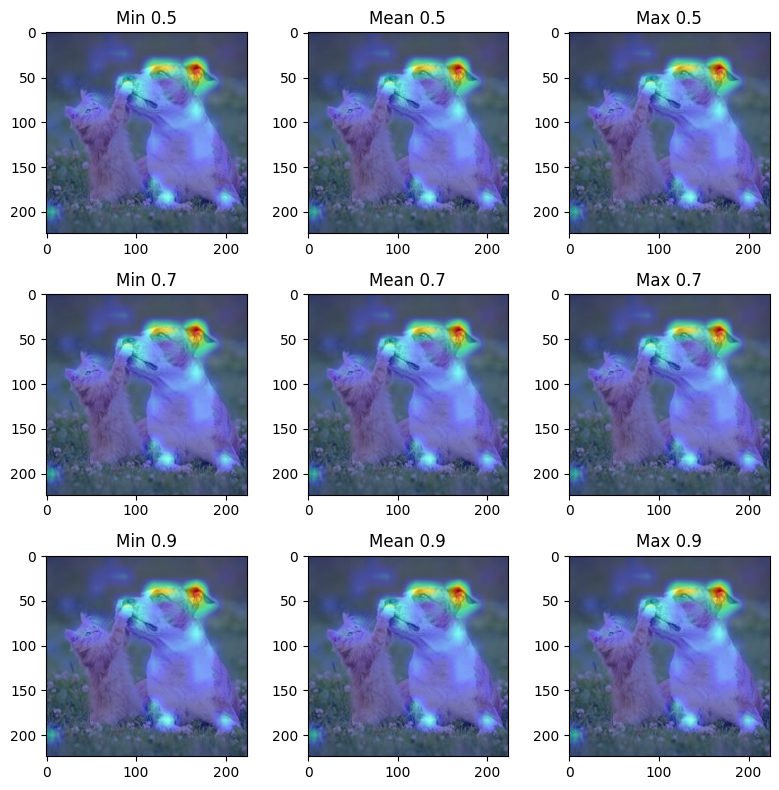

In [14]:
head_fusion_category_images = ['dog_grad_rollout_243_0.500_min.png',
                               'dog_grad_rollout_243_0.500_mean.png',
                               'dog_grad_rollout_243_0.500_max.png',
                               'dog_grad_rollout_243_0.700_min.png',
                               'dog_grad_rollout_243_0.700_mean.png',
                               'dog_grad_rollout_243_0.700_max.png',
                               'dog_grad_rollout_243_0.900_min.png',
                               'dog_grad_rollout_243_0.900_mean.png',
                               'dog_grad_rollout_243_0.900_max.png',
]

head_fusion_category_titles = ['Min 0.5', 'Mean 0.5', 'Max 0.5',
                                  'Min 0.7', 'Mean 0.7', 'Max 0.7',
                                  'Min 0.9', 'Mean 0.9', 'Max 0.9']

plot_images(head_fusion_category_images, head_fusion_category_titles, nrows=3, ncols=3, figsize=(8,8))


## Category visualization

### Dog

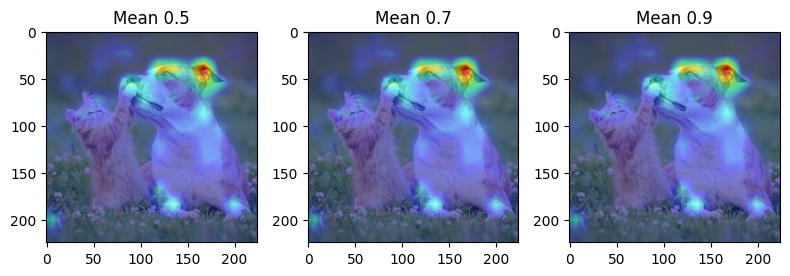

In [15]:
dog_images = ['dog_grad_rollout_243_0.500_mean.png',
              'dog_grad_rollout_243_0.700_mean.png',
              'dog_grad_rollout_243_0.900_mean.png']

dog_titles = ['Mean 0.5', 'Mean 0.7', 'Mean 0.9']

plot_images(dog_images, dog_titles, nrows=1, ncols=3, figsize=(8,8))

### Cat

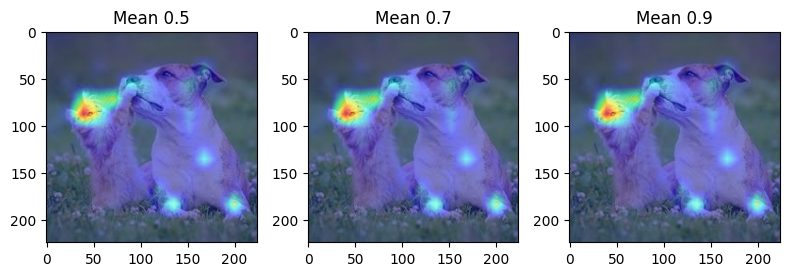

In [16]:
cat_images = ['cat_grad_rollout_282_0.500_mean.png',
              'cat_grad_rollout_282_0.700_mean.png',
              'cat_grad_rollout_282_0.900_mean.png']

cat_titles = ['Mean 0.5', 'Mean 0.7', 'Mean 0.9']

plot_images(cat_images, cat_titles, nrows=1, ncols=3, figsize=(8,8))

### Mix Animals

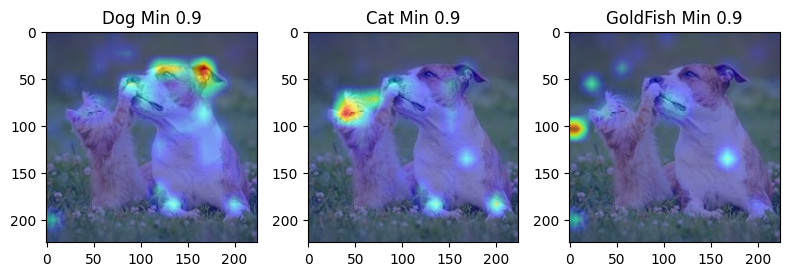

In [17]:
cat_images = ['dog_grad_rollout_243_0.900_min.png',
              'cat_grad_rollout_282_0.900_mean.png',
              'grad_rollout_5_0.900_min.png']

cat_titles = ['Dog Min 0.9', 'Cat Min 0.9', 'GoldFish Min 0.9']


plot_images(cat_images, cat_titles, nrows=1, ncols=3, figsize=(8,8))